# Analyze trained model

## Set up

In [2]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


## Load the trained model

In [4]:
import torch
import yaml

from timescales.rnns.rnn import RNN, RNNLightning
import torch.nn as nn
import glob

model_type = "vanilla"
run_id = "20250821_003413"  # Update this to your actual run ID


run_dir = f"logs/checkpoints/{model_type}_{run_id}"
config_path = f"{run_dir}/config_{run_id}.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

checkpoint_files = glob.glob(f"{run_dir}/best-model-*.ckpt")
print(f"Loading Lightning checkpoint from: {checkpoint_files[0]}")


model = RNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["num_place_cells"],  # Updated parameter name
    alpha=config["alpha"],
    activation=getattr(nn, config["activation"]),
)

rnn_lightning = RNNLightning.load_from_checkpoint(
    checkpoint_files[0],
    model=model,
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"],
    step_size=config["step_size"],
    gamma=config["gamma"],
)

model = rnn_lightning.model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"Loaded model from run: {run_id}")
print(f"Model config: {config_path}")
print(f"Device: {device}")

FileNotFoundError: [Errno 2] No such file or directory: 'logs/checkpoints/vanilla_20250821_003413/config_20250821_003413.yaml'

## Visualize the loss curves

Loaded loss data from: logs/checkpoints/vanilla_20250821_003413/training_losses.json
Training epochs: 99


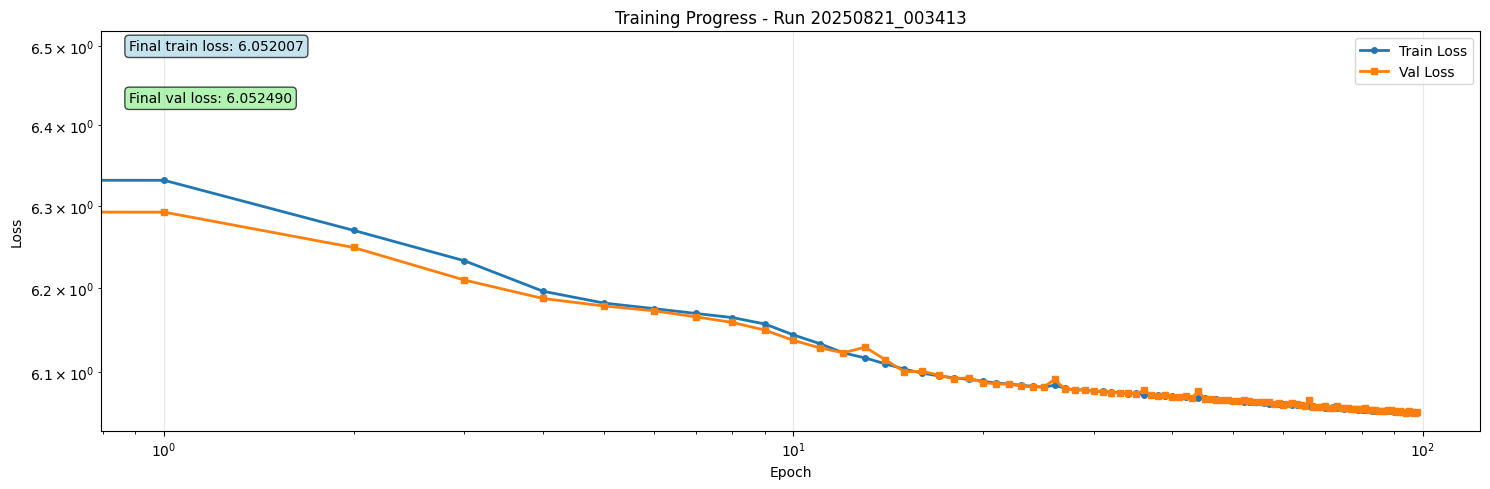

Initial train loss: 6.4953
Final train loss: 6.0520
Initial val loss: 6.3855
Final val loss: 6.0525
Best val loss: 6.051881 at epoch 97


In [4]:
from pirnns.analysis import plot_loss_curves

plot_loss_curves(
    loss_file=f"{run_dir}/training_losses.json",
    title=f"Training Progress - Run {run_id}",
    log_x=True,
    log_y=True,
)

## Load evaluation datamodule

In [5]:
from datamodule import PathIntegrationDataModule

num_trajectories = 10000
batch_size = 1

eval_datamodule = PathIntegrationDataModule(
    num_trajectories=num_trajectories,
    batch_size=batch_size,
    num_workers=1,
    train_val_split=0.0,
    velocity_representation=config["velocity_representation"],
    dt=config["dt"],
    num_time_steps=config["num_time_steps"],
    arena_size=config["arena_size"],  # Changed from arena_L
    speed_scale=config["speed_scale"],  # Changed from mu_speed
    sigma_speed=config["sigma_speed"],
    tau_vel=config["tau_vel"],
    sigma_rotation=config["sigma_rotation"],
    border_region=config["border_region"],
    num_place_cells=config["num_place_cells"],
    place_cell_rf=config["place_cell_rf"],
    surround_scale=config["surround_scale"],
    DoG=config["DoG"],
    trajectory_type=config["trajectory_type"],
    place_cell_layout=config["place_cell_layout"],
)

eval_datamodule.setup()

eval_loader = eval_datamodule.val_dataloader()

print(f"Number of validation batches: {len(eval_loader)}")
print(f"Validation dataset size: {len(eval_datamodule.val_dataset)}")

Number of validation batches: 10000
Validation dataset size: 10000


## Visualize hidden unit activations over space

Computing spatial rate maps using 10000 trajectories...
Spatial grid: 44 x 44 bins of size 0.05
Hidden units to analyze: 4096
Processed 1/10000 trajectories...
Processed 51/10000 trajectories...
Processed 101/10000 trajectories...
Processed 151/10000 trajectories...
Processed 201/10000 trajectories...
Processed 251/10000 trajectories...
Processed 301/10000 trajectories...
Processed 351/10000 trajectories...
Processed 401/10000 trajectories...
Processed 451/10000 trajectories...
Processed 501/10000 trajectories...
Processed 551/10000 trajectories...
Processed 601/10000 trajectories...
Processed 651/10000 trajectories...
Processed 701/10000 trajectories...
Processed 751/10000 trajectories...
Processed 801/10000 trajectories...
Processed 851/10000 trajectories...
Processed 901/10000 trajectories...
Processed 951/10000 trajectories...
Processed 1001/10000 trajectories...
Processed 1051/10000 trajectories...
Processed 1101/10000 trajectories...
Processed 1151/10000 trajectories...
Processed

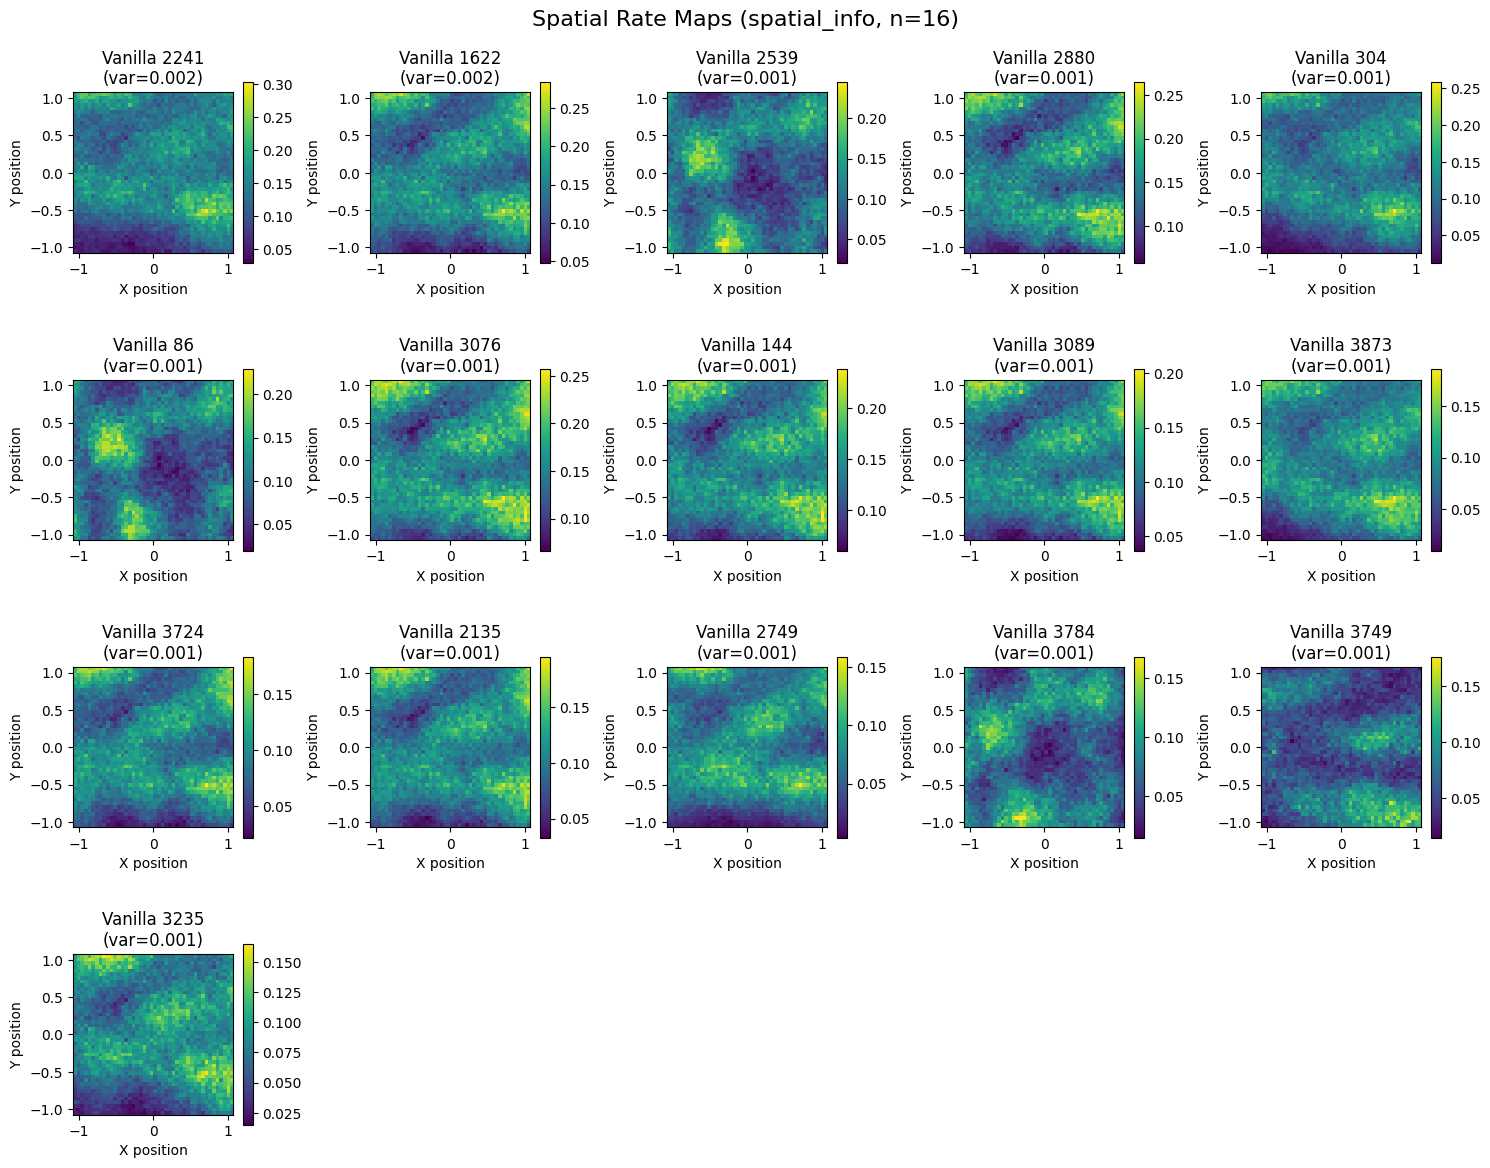

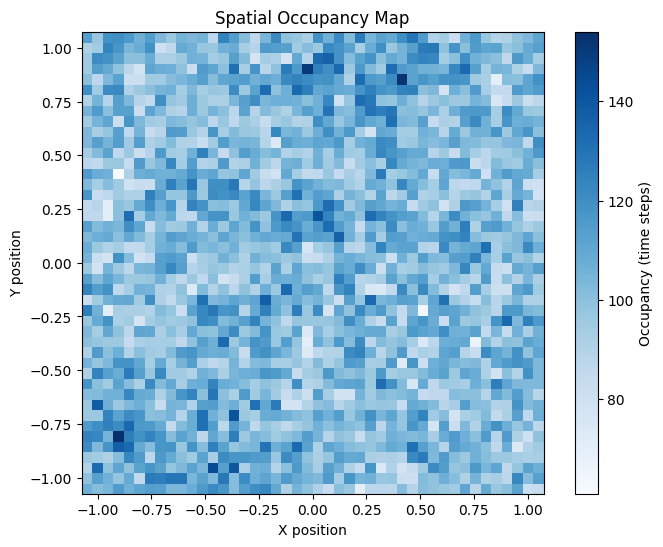

In [13]:
from pirnns.analysis.spatial import SpatialAnalyzer

spatial = SpatialAnalyzer(
    model=model,
    device=device,
    model_type=model_type,
    population_to_visualize="pop1",
)

spatial.compute_rate_maps(
    eval_loader=eval_loader,
    arena_size=config["arena_size"],
    bin_size=0.05,
    num_trajectories=10000,
    min_occupancy=10,
).plot_rate_maps(num_units=16, selection_method="spatial_info").plot_occupancy_map();

## Principal Component Analysis

Compare with untrained model.

Computing hidden states from 1000 batches...
Processed batch 1/1000
Processed batch 101/1000
Processed batch 201/1000
Processed batch 301/1000
Processed batch 401/1000
Processed batch 501/1000
Processed batch 601/1000
Processed batch 701/1000
Processed batch 801/1000
Processed batch 901/1000
Hidden states computed:
  Trained shape: torch.Size([1000, 20, 4096])
  Untrained shape: torch.Size([1000, 20, 4096])
Computing PCA with 100 components...
Data shapes for PCA:
  Trained: torch.Size([20000, 4096])
  Untrained: torch.Size([20000, 4096])
  Ratio (samples/features): 4.88
PCA completed:
  Trained variance explained: 98.03%
  Untrained variance explained: 97.99%


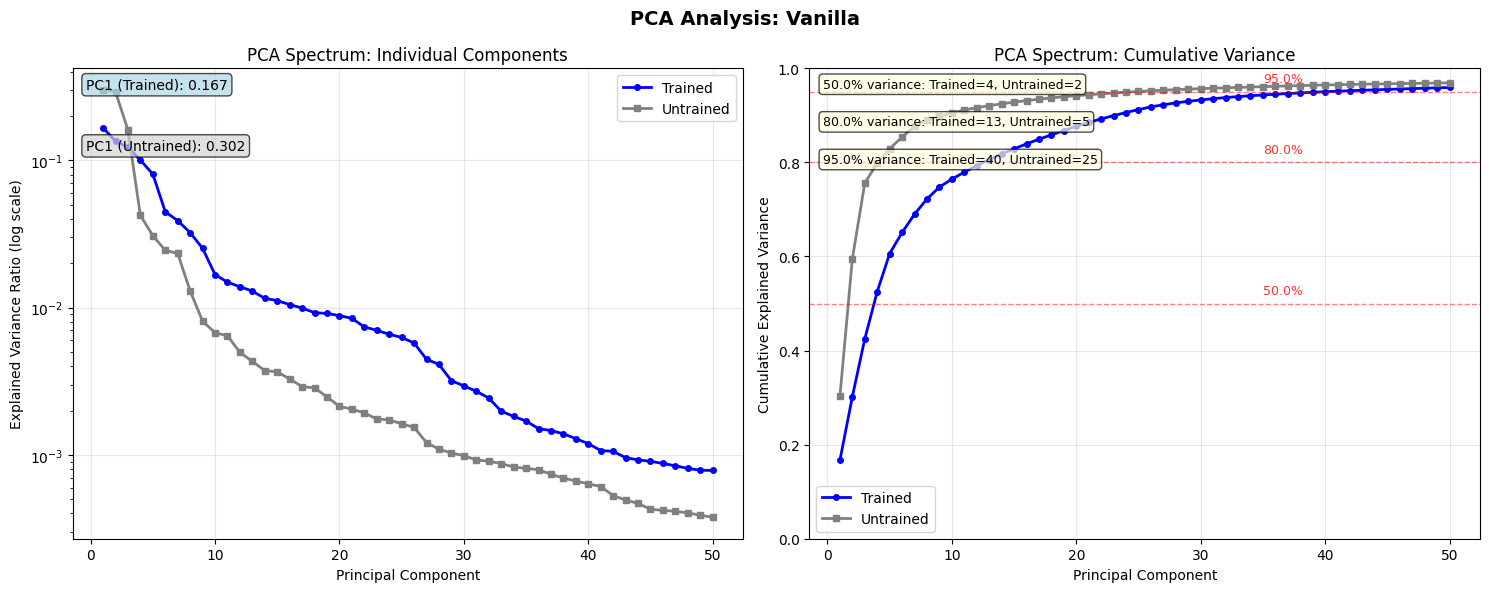


=== PCA Spectrum Analysis for Vanilla ===
First 10 components (Trained):   [0.16677275 0.13513951 0.12297132 0.10054635 0.08077082 0.04480399
 0.03900353 0.03234036 0.02530534 0.01678638]
First 10 components (Untrained): [0.30244809 0.2927075  0.16096287 0.04228919 0.03087632 0.02451182
 0.02336292 0.0129906  0.00809606 0.00675903]

Variance explained by first N components:
   1 components: Trained=0.167, Untrained=0.302
   2 components: Trained=0.302, Untrained=0.595
   5 components: Trained=0.606, Untrained=0.829
  10 components: Trained=0.764, Untrained=0.905
  20 components: Trained=0.877, Untrained=0.942

Effective dimensionality (95% variance):
  Trained:   40 components
  Untrained: 25 components

First PC dominance:
  Trained PC1 explains 16.7% of variance
  Untrained PC1 explains 30.2% of variance
  → Trained model shows structured low-dimensional dynamics
  → Untrained model shows some structure (unexpected)


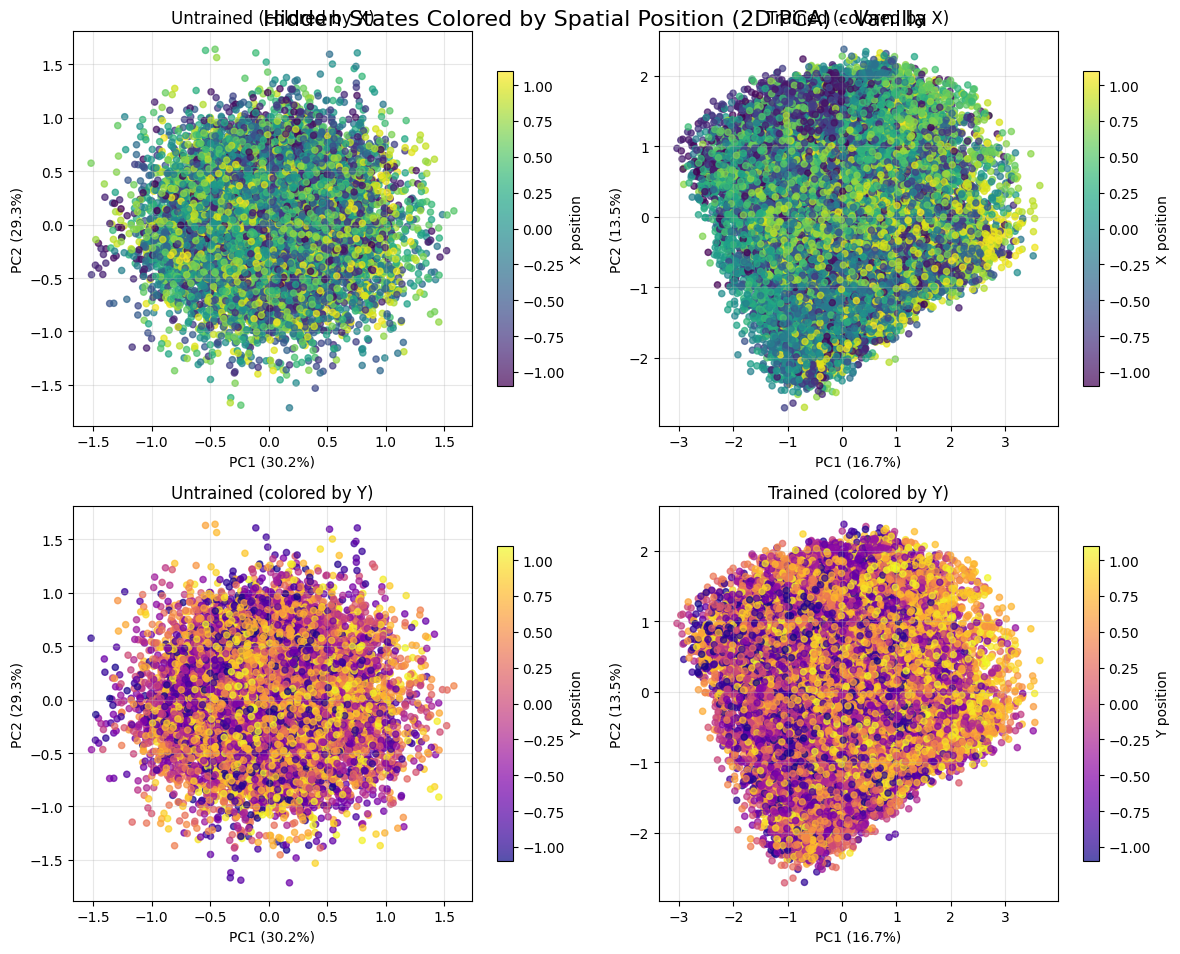

In [6]:
from pirnns.analysis.dynamics import DynamicsAnalyzer

from pirnns.rnns.rnn import RNN
import torch.nn as nn

untrained_model = RNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["num_place_cells"],
    alpha=config["alpha"],
    activation=getattr(nn, config["activation"]),
)

untrained_model.to(device)
untrained_model.eval()

dynamics = (
    DynamicsAnalyzer(
        trained_model=model,
        untrained_model=untrained_model,
        device=device,
        model_type=model_type,
        population_to_visualize="pop1",
    )
    .compute_hidden_states(eval_loader=eval_loader, num_batches=1000)
    .compute_pca(n_components=100)
    .plot_pca_spectrum()
    .plot_2d_pca_trajectories()
)

Computing hidden states from 1000 batches...
Processed batch 1/1000
Processed batch 101/1000
Processed batch 201/1000
Processed batch 301/1000
Processed batch 401/1000
Processed batch 501/1000
Processed batch 601/1000
Processed batch 701/1000
Processed batch 801/1000
Processed batch 901/1000
Hidden states computed:
  Trained shape: torch.Size([1000, 20, 4096])
  Untrained shape: torch.Size([1000, 20, 4096])
Computing PCA with 100 components...
Data shapes for PCA:
  Trained: torch.Size([20000, 4096])
  Untrained: torch.Size([20000, 4096])
  Ratio (samples/features): 4.88
PCA completed:
  Trained variance explained: 98.03%
  Untrained variance explained: 97.99%


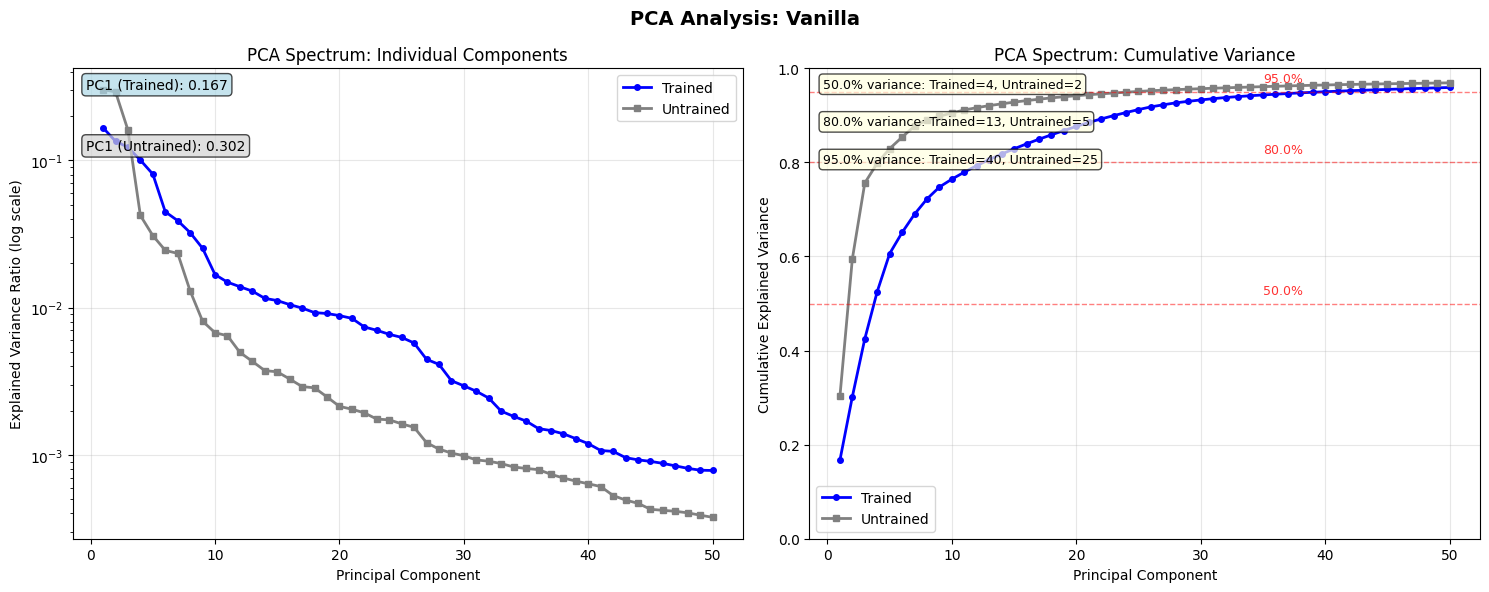


=== PCA Spectrum Analysis for Vanilla ===
First 10 components (Trained):   [0.16677275 0.13513951 0.12297132 0.10054635 0.08077082 0.04480399
 0.03900353 0.03234036 0.02530534 0.01678638]
First 10 components (Untrained): [0.30244809 0.2927075  0.16096287 0.04228919 0.03087632 0.02451182
 0.02336292 0.0129906  0.00809606 0.00675903]

Variance explained by first N components:
   1 components: Trained=0.167, Untrained=0.302
   2 components: Trained=0.302, Untrained=0.595
   5 components: Trained=0.606, Untrained=0.829
  10 components: Trained=0.764, Untrained=0.905
  20 components: Trained=0.877, Untrained=0.942

Effective dimensionality (95% variance):
  Trained:   40 components
  Untrained: 25 components

First PC dominance:
  Trained PC1 explains 16.7% of variance
  Untrained PC1 explains 30.2% of variance
  → Trained model shows structured low-dimensional dynamics
  → Untrained model shows some structure (unexpected)


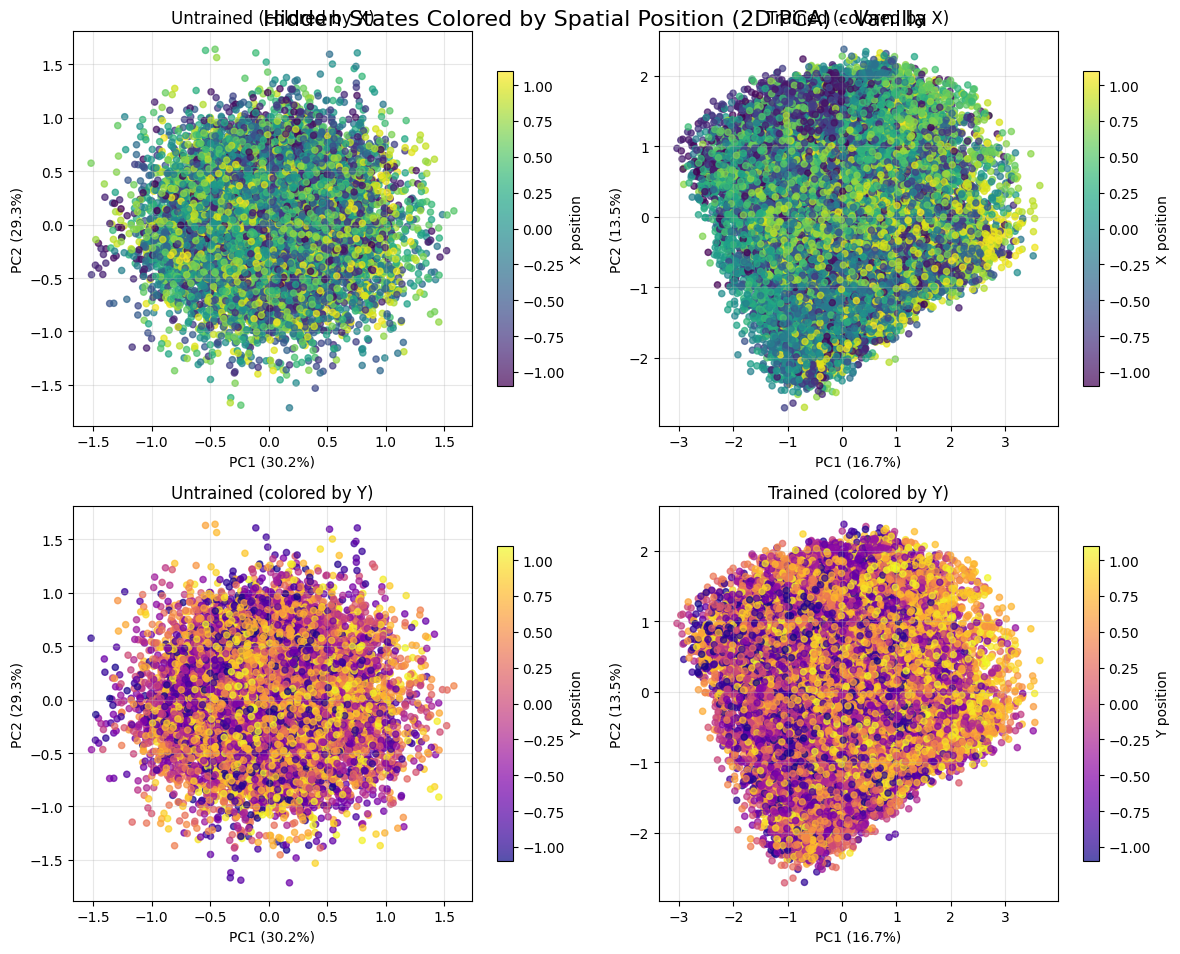

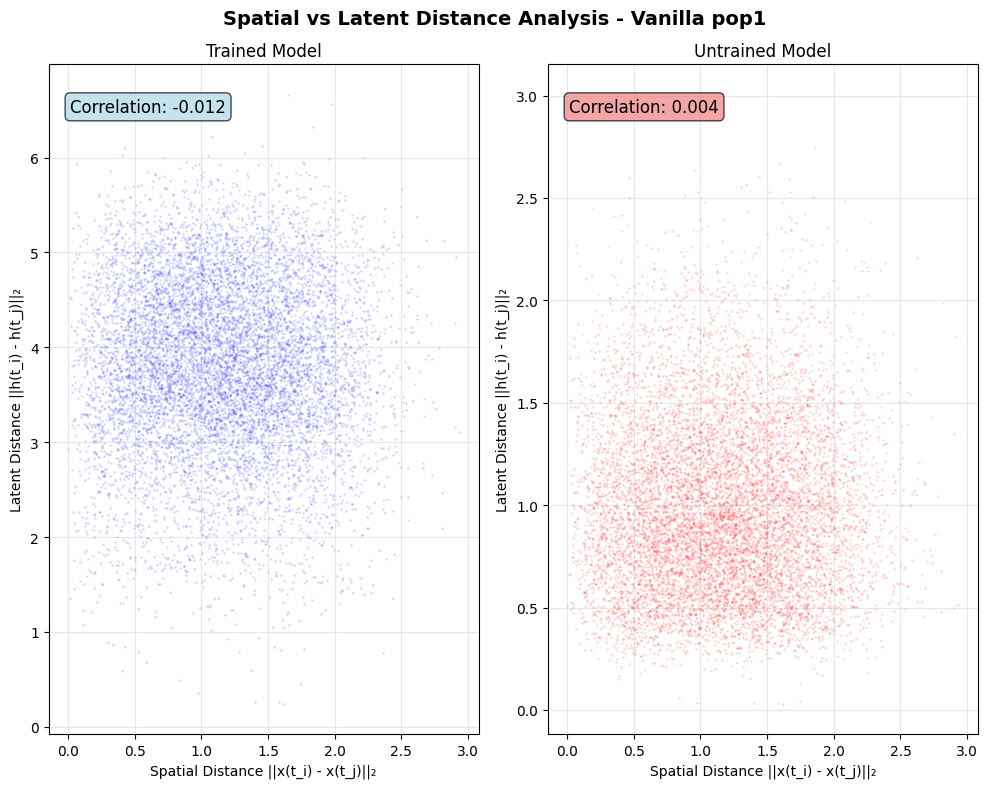


=== Spatial vs Latent Distance Analysis ===
Number of timepoint pairs analyzed: 10000
Spatial distance range: [0.002, 2.933]
Trained latent distance range: [0.2, 6.7]
Untrained latent distance range: [0.0, 3.0]
Trained correlation (spatial vs latent): -0.012
Untrained correlation (spatial vs latent): 0.004
⚠ Trained model shows weak spatial structure preservation


In [8]:
# Add this to your existing dynamics analysis chain:
dynamics = (
    DynamicsAnalyzer(
        trained_model=model,
        untrained_model=untrained_model,
        device=device,
        model_type=model_type,
        population_to_visualize="pop1",
    )
    .compute_hidden_states(eval_loader=eval_loader, num_batches=1000)
    .compute_pca(n_components=100)
    .plot_pca_spectrum()
    .plot_2d_pca_trajectories()
    .plot_spatial_vs_latent_distance(num_pairs=10000)  # Add this line!
)

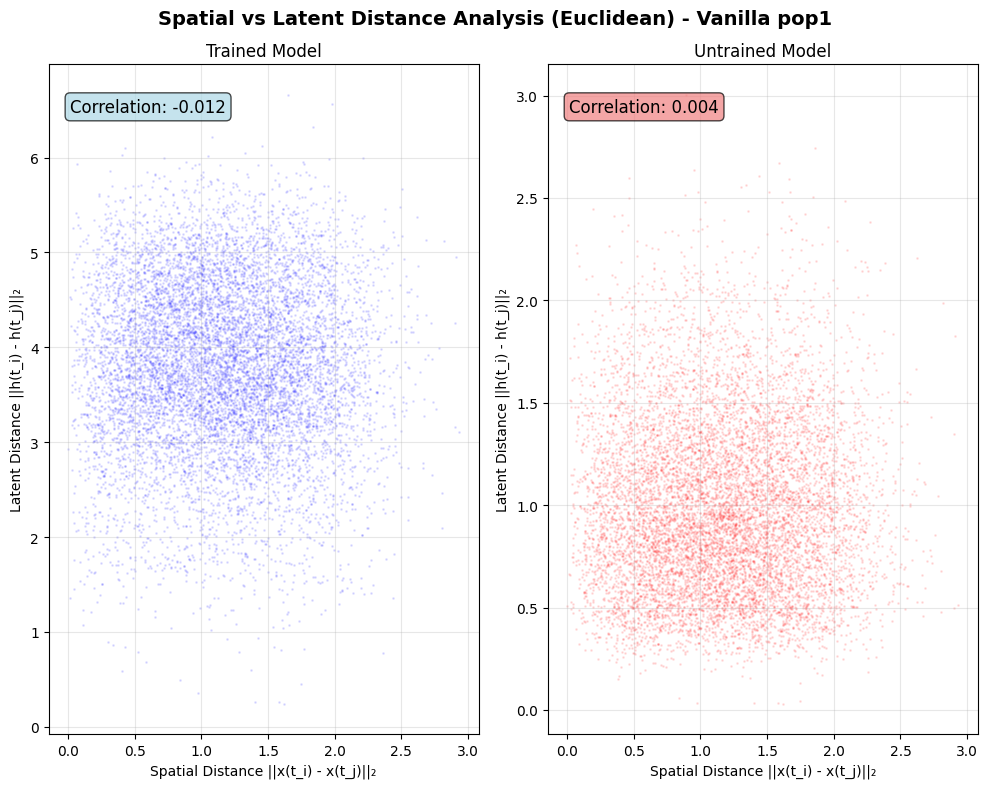


=== Spatial vs Latent Distance Analysis (Euclidean) ===
Number of timepoint pairs analyzed: 10000
Spatial distance range: [0.002, 2.933]
Trained latent distance range: [0.243, 6.662]
Untrained latent distance range: [0.030, 3.004]
Trained correlation (spatial vs latent): -0.012
Untrained correlation (spatial vs latent): 0.004


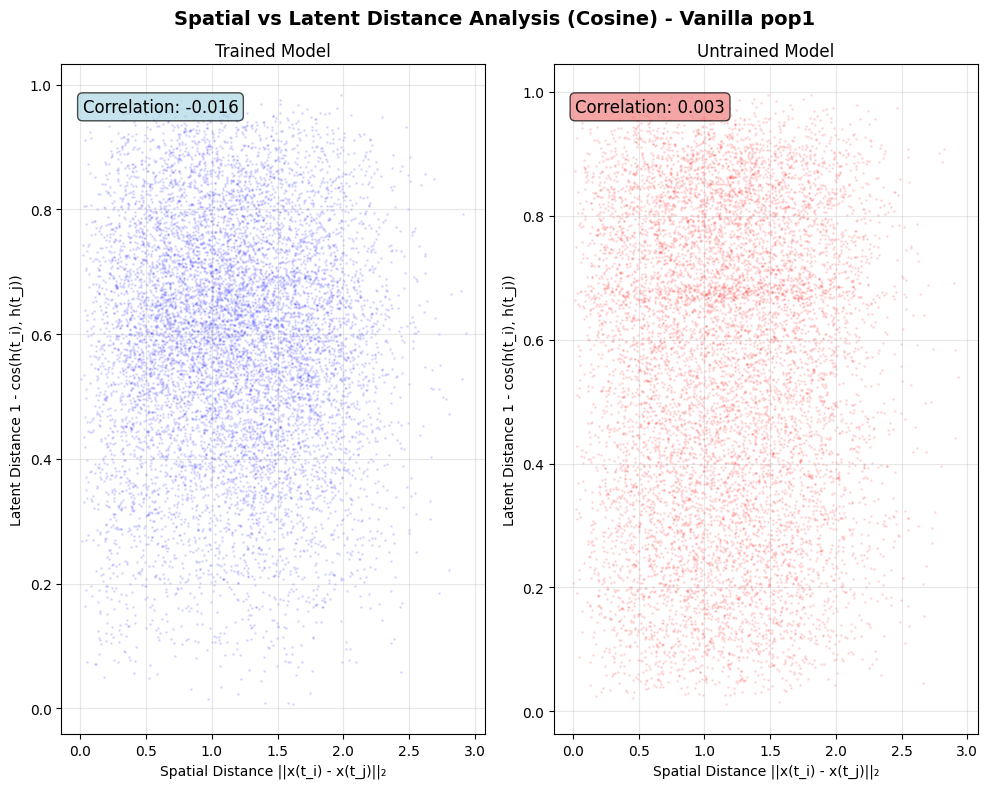


=== Spatial vs Latent Distance Analysis (Cosine) ===
Number of timepoint pairs analyzed: 10000
Spatial distance range: [0.002, 2.933]
Trained latent distance range: [0.007, 0.984]
Untrained latent distance range: [0.012, 0.995]
Trained correlation (spatial vs latent): -0.016
Untrained correlation (spatial vs latent): 0.003

Note: Cosine distance measures angular similarity, independent of vector magnitude


In [10]:
dynamics.plot_spatial_vs_latent_distance(distance_metric="euclidean")
dynamics.plot_spatial_vs_latent_distance(distance_metric="cosine")